In [1]:
import pandas as pd
from DS_Helpers.filters import column_filter
from DS_Helpers.data import EmbeddingCreator, other_generator, other_generator_columns, find_embed_object_cols, get_days_to_nearest_holiday, find_optimal_clusters
from DS_Helpers.metrics import classification_result
from DS_Helpers.models import pipeline_Classifier, preprocessing, simple_preprocessing, log_scaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, make_scorer, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
import matplotlib.pyplot as plt

In [2]:
leads = column_filter(pd.read_csv('data/leads_dataset.csv'), tolerance=0.4)
leads.LEAD_CREATED_AT_UTC = pd.to_datetime(leads.LEAD_CREATED_AT_UTC)


infutor_enrichment_dataset = column_filter(pd.read_csv('data/infutor_enrichment_dataset.csv', index_col=0), tolerance=0.4)
zip_code_dataset = column_filter(pd.read_csv('data/zip_code_dataset.csv'), tolerance=0.3)

In [3]:
leads.head()

,HASHED_PHONE_NUMBER,IS_APPOINTMENT_SET,LEAD_CREATED_AT_UTC,ZIP_CODE,CITY,STATE,COUNTY,EMAIL_DOMAIN,OPERATINGSYSTEMCLASS,OPERATINGSYSTEMNAME,AGENTNAME,AGENTVERSIONMAJOR,DEVICEBRAND,DEVICENAME,LAYOUTENGINENAME,NETWORKTYPE,OPERATINGSYSTEMVERSIONMAJOR,WEBVIEWAPPNAME
0,16bc446a779996bf3007065819f1dd4692a17d14,True,2023-07-18 15:11:55+00:00,61080.0,South Beloit,IL,Winnebago,gmail.com,Mobile,Android,Chrome Webview,114,Samsung,Samsung SM-A546V,Blink,Unknown,13,Newsbreak
1,6d30f0d0f87d39f8c178e3750072eef79bb9d7a0,False,2022-09-19 18:37:21+00:00,33914.0,Cape Coral,FL,Lee,gmail.com,Mobile,iOS,UIWebView,605,Apple,Apple iPhone,AppleWebKit,Unknown,15,Facebook App for iOS
2,9de207ef32d3696829ae369c2a9a4500cd36ec43,True,2022-11-09 21:38:10+00:00,42055.0,Kuttawa,KY,Lyon,gmail.com,Mobile,Android,Chrome Webview,105,Samsung,Samsung SM-G991U,Blink,Unknown,12,Facebook App for Android
3,31bb43ece722562df3a163ba94be4eb2ccd1bf71,False,2022-11-13 15:41:31+00:00,43701.0,Zanesville,OH,Muskingum,gmail.com,Mobile,iOS,UIWebView,605,Apple,Apple iPhone,AppleWebKit,Unknown,15,Facebook App for iOS
4,674de0e7b4da1c9945422b248f94cbf2499d59e2,False,2022-10-07 17:56:51+00:00,22206.0,Arlington,VA,Arlington,gmail.com,Mobile,iOS,UIWebView,605,Apple,Apple iPhone,AppleWebKit,Unknown,16,Facebook App for iOS


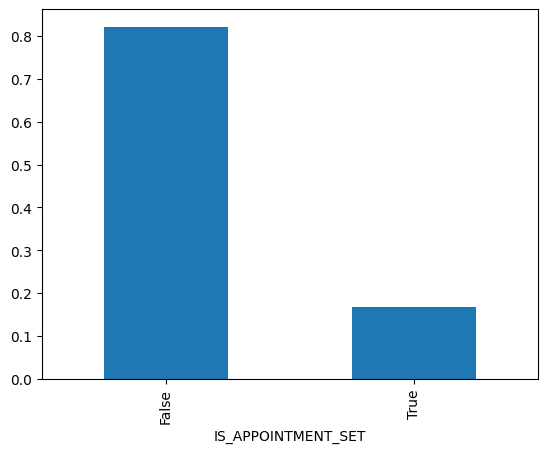

In [4]:
(leads.IS_APPOINTMENT_SET.value_counts()/leads.shape[0]).plot.bar();

In [5]:
infutor_enrichment_dataset.dtypes

HASHED_PHONE_NUMBER                                      object
MATCHLEVEL                                                int64
ATTRIBUTES_COREDEMOGRAPHICS_DOB                         float64
ATTRIBUTES_COREDEMOGRAPHICS_GENDER                       object
ATTRIBUTES_COREDEMOGRAPHICS_MARRIEDCD                    object
ATTRIBUTES_COREDEMOGRAPHICS_WEALTHSCR                    object
ATTRIBUTES_COREDEMOGRAPHICS_HOMEOWNERCD                  object
ATTRIBUTES_COREDEMOGRAPHICS_EHI                          object
ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_CREDITCARD           object
ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_YRBLD               float64
ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_LOR                 float64
ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_HHNBR               float64
ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_CENS_POP_DENSITY    float64
dtype: object

In [6]:
infutor_enrichment_dataset.head()

,HASHED_PHONE_NUMBER,MATCHLEVEL,ATTRIBUTES_COREDEMOGRAPHICS_DOB,ATTRIBUTES_COREDEMOGRAPHICS_GENDER,ATTRIBUTES_COREDEMOGRAPHICS_MARRIEDCD,ATTRIBUTES_COREDEMOGRAPHICS_WEALTHSCR,ATTRIBUTES_COREDEMOGRAPHICS_HOMEOWNERCD,ATTRIBUTES_COREDEMOGRAPHICS_EHI,ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_CREDITCARD,ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_YRBLD,ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_LOR,ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_HHNBR,ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_CENS_POP_DENSITY
0,9a99e383ee68a51c2740de9883f5b1bee5d2a4da,1,197010.0,M,M,A,H,J,Y,1959.0,6.0,2.0,3801.0
1,0020b0a911711b66c100d7e8e25e226783bb0072,5,194702.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,d436912ed29db2950ca13b64cc56fefc0f581f7a,1,196410.0,F,M,E,H,I,Y,NaN,9.0,2.0,294.0
3,c2bd44a987bc7b9663352235ea2b7bb04b696697,5,NaN,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,c363fb2c7bbdd728928716b4d5b4a80a13cbd2f2,1,197009.0,M,S,D,U,E,Y,NaN,15.0,2.0,NaN


In [7]:
data = pd.merge(left=leads, right=infutor_enrichment_dataset, on='HASHED_PHONE_NUMBER', how='left')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318565 entries, 0 to 318564
Data columns (total 30 columns):
 #   Column                                                Non-Null Count   Dtype              
---  ------                                                --------------   -----              
 0   HASHED_PHONE_NUMBER                                   318565 non-null  object             
 1   IS_APPOINTMENT_SET                                    315348 non-null  object             
 2   LEAD_CREATED_AT_UTC                                   315348 non-null  datetime64[ns, UTC]
 3   ZIP_CODE                                              315348 non-null  float64            
 4   CITY                                                  315309 non-null  object             
 5   STATE                                                 315309 non-null  object             
 6   COUNTY                                                315309 non-null  object             
 7   EMAIL_DOMAIN        

In [8]:
zip_code_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19692 entries, 0 to 19691
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ZIP_CODE            19691 non-null  float64
 1   Alchemist           19691 non-null  float64
 2   Ancient Apparition  19691 non-null  float64
 3   Anti-Mage           19691 non-null  float64
 4   Axe                 19691 non-null  float64
 5   Batrider            19691 non-null  float64
 6   Beastmaster         19691 non-null  float64
 7   Chaos Knight        19691 non-null  float64
 8   Chen                19691 non-null  float64
 9   Clinkz              19691 non-null  float64
 10  Clockwerk           19691 non-null  float64
 11  Crystal Maiden      19691 non-null  float64
 12  Dark Seer           19691 non-null  float64
 13  Dazzle              19691 non-null  float64
 14  Death Prophet       19691 non-null  float64
 15  Doom                19691 non-null  float64
 16  Drag

In [9]:
zip_code_dataset.head()

,ZIP_CODE,Alchemist,Ancient Apparition,Anti-Mage,Axe,Batrider,Beastmaster,Chaos Knight,Chen,Clinkz,...,Dragon Knight,Drow Ranger,Earth Spirit,Earthshaker,Elder Titan,Ember Spirit,Enchantress,Enigma,Faceless Void,Pudge
0,47327.0,2065.0,1403.0,40.5,42.1,18.0,7.0,93.0,62.0,26.0,...,1081.0,840.0,16.0,14.0,25.0,12.0,76.0,83.0,3.0,1952.0
1,71268.0,347.0,257.0,40.6,40.6,17.0,7.0,93.0,62.0,34.0,...,1205.0,910.0,21.0,21.0,31.0,16.0,90.0,74.0,0.0,1991.0
2,27828.0,3581.0,2519.0,39.2,38.8,17.0,10.0,90.0,59.0,29.0,...,1533.0,1288.0,24.0,20.0,34.0,21.0,68.0,73.0,3.0,1990.0
3,30143.0,7863.0,5681.0,46.4,49.5,27.0,2.0,98.0,75.0,29.0,...,2654.0,2445.0,9.0,9.0,14.0,9.0,79.0,84.0,1.0,1994.0
4,25564.0,90.0,77.0,37.4,36.8,20.0,2.0,98.0,77.0,16.0,...,1545.0,1125.0,0.0,22.0,0.0,0.0,80.0,68.0,0.0,1987.0


In [10]:
data = pd.merge(left=data, right=zip_code_dataset, on='ZIP_CODE', how='left')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334904 entries, 0 to 334903
Data columns (total 55 columns):
 #   Column                                                Non-Null Count   Dtype              
---  ------                                                --------------   -----              
 0   HASHED_PHONE_NUMBER                                   334904 non-null  object             
 1   IS_APPOINTMENT_SET                                    331687 non-null  object             
 2   LEAD_CREATED_AT_UTC                                   331687 non-null  datetime64[ns, UTC]
 3   ZIP_CODE                                              331687 non-null  float64            
 4   CITY                                                  331648 non-null  object             
 5   STATE                                                 331648 non-null  object             
 6   COUNTY                                                331648 non-null  object             
 7   EMAIL_DOMAIN        

In [11]:
data.head()

,HASHED_PHONE_NUMBER,IS_APPOINTMENT_SET,LEAD_CREATED_AT_UTC,ZIP_CODE,CITY,STATE,COUNTY,EMAIL_DOMAIN,OPERATINGSYSTEMCLASS,OPERATINGSYSTEMNAME,...,Dragon Knight,Drow Ranger,Earth Spirit,Earthshaker,Elder Titan,Ember Spirit,Enchantress,Enigma,Faceless Void,Pudge
0,16bc446a779996bf3007065819f1dd4692a17d14,True,2023-07-18 15:11:55+00:00,61080.0,South Beloit,IL,Winnebago,gmail.com,Mobile,Android,...,1385.0,1244.0,7.0,10.0,13.0,4.0,71.0,87.0,3.0,1984.0
1,6d30f0d0f87d39f8c178e3750072eef79bb9d7a0,False,2022-09-19 18:37:21+00:00,33914.0,Cape Coral,FL,Lee,gmail.com,Mobile,iOS,...,3253.0,2845.0,9.0,8.0,15.0,6.0,78.0,83.0,3.0,1998.0
2,9de207ef32d3696829ae369c2a9a4500cd36ec43,True,2022-11-09 21:38:10+00:00,42055.0,Kuttawa,KY,Lyon,gmail.com,Mobile,Android,...,1400.0,1098.0,16.0,6.0,31.0,12.0,91.0,60.0,0.0,1981.0
3,31bb43ece722562df3a163ba94be4eb2ccd1bf71,False,2022-11-13 15:41:31+00:00,43701.0,Zanesville,OH,Muskingum,gmail.com,Mobile,iOS,...,1464.0,1140.0,20.0,18.0,33.0,23.0,63.0,72.0,4.0,1964.0
4,674de0e7b4da1c9945422b248f94cbf2499d59e2,False,2022-10-07 17:56:51+00:00,22206.0,Arlington,VA,Arlington,gmail.com,Mobile,iOS,...,4399.0,4375.0,4.0,3.0,4.0,2.0,55.0,45.0,1.0,1948.0


In [12]:
get_days_to_nearest_holiday(date_input=data.LEAD_CREATED_AT_UTC[0], country_code='US')

14

In [13]:
data['days_to_holiday'] = data['LEAD_CREATED_AT_UTC'].apply(lambda x: get_days_to_nearest_holiday(x, country_code='US') if pd.notnull(x) else None)
data.head()


,HASHED_PHONE_NUMBER,IS_APPOINTMENT_SET,LEAD_CREATED_AT_UTC,ZIP_CODE,CITY,STATE,COUNTY,EMAIL_DOMAIN,OPERATINGSYSTEMCLASS,OPERATINGSYSTEMNAME,...,Drow Ranger,Earth Spirit,Earthshaker,Elder Titan,Ember Spirit,Enchantress,Enigma,Faceless Void,Pudge,days_to_holiday
0,16bc446a779996bf3007065819f1dd4692a17d14,True,2023-07-18 15:11:55+00:00,61080.0,South Beloit,IL,Winnebago,gmail.com,Mobile,Android,...,1244.0,7.0,10.0,13.0,4.0,71.0,87.0,3.0,1984.0,14.0
1,6d30f0d0f87d39f8c178e3750072eef79bb9d7a0,False,2022-09-19 18:37:21+00:00,33914.0,Cape Coral,FL,Lee,gmail.com,Mobile,iOS,...,2845.0,9.0,8.0,15.0,6.0,78.0,83.0,3.0,1998.0,14.0
2,9de207ef32d3696829ae369c2a9a4500cd36ec43,True,2022-11-09 21:38:10+00:00,42055.0,Kuttawa,KY,Lyon,gmail.com,Mobile,Android,...,1098.0,16.0,6.0,31.0,12.0,91.0,60.0,0.0,1981.0,2.0
3,31bb43ece722562df3a163ba94be4eb2ccd1bf71,False,2022-11-13 15:41:31+00:00,43701.0,Zanesville,OH,Muskingum,gmail.com,Mobile,iOS,...,1140.0,20.0,18.0,33.0,23.0,63.0,72.0,4.0,1964.0,2.0
4,674de0e7b4da1c9945422b248f94cbf2499d59e2,False,2022-10-07 17:56:51+00:00,22206.0,Arlington,VA,Arlington,gmail.com,Mobile,iOS,...,4375.0,4.0,3.0,4.0,2.0,55.0,45.0,1.0,1948.0,3.0


In [14]:
data = data[ ~data.IS_APPOINTMENT_SET.isna() ]
data = data.drop( labels='HASHED_PHONE_NUMBER ZIP_CODE'.split(), axis=1 )
data.shape

(331687, 54)

In [15]:
y = data.IS_APPOINTMENT_SET
X = data.drop(labels='IS_APPOINTMENT_SET', axis=1)
X.head()

,LEAD_CREATED_AT_UTC,CITY,STATE,COUNTY,EMAIL_DOMAIN,OPERATINGSYSTEMCLASS,OPERATINGSYSTEMNAME,AGENTNAME,AGENTVERSIONMAJOR,DEVICEBRAND,...,Drow Ranger,Earth Spirit,Earthshaker,Elder Titan,Ember Spirit,Enchantress,Enigma,Faceless Void,Pudge,days_to_holiday
0,2023-07-18 15:11:55+00:00,South Beloit,IL,Winnebago,gmail.com,Mobile,Android,Chrome Webview,114,Samsung,...,1244.0,7.0,10.0,13.0,4.0,71.0,87.0,3.0,1984.0,14.0
1,2022-09-19 18:37:21+00:00,Cape Coral,FL,Lee,gmail.com,Mobile,iOS,UIWebView,605,Apple,...,2845.0,9.0,8.0,15.0,6.0,78.0,83.0,3.0,1998.0,14.0
2,2022-11-09 21:38:10+00:00,Kuttawa,KY,Lyon,gmail.com,Mobile,Android,Chrome Webview,105,Samsung,...,1098.0,16.0,6.0,31.0,12.0,91.0,60.0,0.0,1981.0,2.0
3,2022-11-13 15:41:31+00:00,Zanesville,OH,Muskingum,gmail.com,Mobile,iOS,UIWebView,605,Apple,...,1140.0,20.0,18.0,33.0,23.0,63.0,72.0,4.0,1964.0,2.0
4,2022-10-07 17:56:51+00:00,Arlington,VA,Arlington,gmail.com,Mobile,iOS,UIWebView,605,Apple,...,4375.0,4.0,3.0,4.0,2.0,55.0,45.0,1.0,1948.0,3.0


In [16]:
X['Year'] = X.LEAD_CREATED_AT_UTC.dt.year
X['Month'] = X.LEAD_CREATED_AT_UTC.dt.month.astype('str')
X['Weekday'] = X.LEAD_CREATED_AT_UTC.dt.weekday.astype('str')
X['Day'] = X.LEAD_CREATED_AT_UTC.dt.day.astype('str')
X['Hour'] = X.LEAD_CREATED_AT_UTC.dt.hour.astype('str')
X = X.drop(labels='LEAD_CREATED_AT_UTC',axis=1)
X.head()

,CITY,STATE,COUNTY,EMAIL_DOMAIN,OPERATINGSYSTEMCLASS,OPERATINGSYSTEMNAME,AGENTNAME,AGENTVERSIONMAJOR,DEVICEBRAND,DEVICENAME,...,Enchantress,Enigma,Faceless Void,Pudge,days_to_holiday,Year,Month,Weekday,Day,Hour
0,South Beloit,IL,Winnebago,gmail.com,Mobile,Android,Chrome Webview,114,Samsung,Samsung SM-A546V,...,71.0,87.0,3.0,1984.0,14.0,2023,7,1,18,15
1,Cape Coral,FL,Lee,gmail.com,Mobile,iOS,UIWebView,605,Apple,Apple iPhone,...,78.0,83.0,3.0,1998.0,14.0,2022,9,0,19,18
2,Kuttawa,KY,Lyon,gmail.com,Mobile,Android,Chrome Webview,105,Samsung,Samsung SM-G991U,...,91.0,60.0,0.0,1981.0,2.0,2022,11,2,9,21
3,Zanesville,OH,Muskingum,gmail.com,Mobile,iOS,UIWebView,605,Apple,Apple iPhone,...,63.0,72.0,4.0,1964.0,2.0,2022,11,6,13,15
4,Arlington,VA,Arlington,gmail.com,Mobile,iOS,UIWebView,605,Apple,Apple iPhone,...,55.0,45.0,1.0,1948.0,3.0,2022,10,4,7,17


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [18]:
X_train = other_generator_columns(df=X_train, other_threshold=50)
X_train.head()

,CITY,STATE,COUNTY,EMAIL_DOMAIN,OPERATINGSYSTEMCLASS,OPERATINGSYSTEMNAME,AGENTNAME,AGENTVERSIONMAJOR,DEVICEBRAND,DEVICENAME,...,Enchantress,Enigma,Faceless Void,Pudge,days_to_holiday,Year,Month,Weekday,Day,Hour
167862,Grand Prairie,TX,Dallas,yahoo.com,Mobile,iOS,UIWebView,605,Apple,Apple iPhone,...,73.0,82.0,1.0,1993.0,4.0,2022,12,2,21,18
24856,Newport,OH,Washington,aol.com,Desktop,Windows NT,Chrome,100,Unknown,Desktop,...,67.0,87.0,0.0,1974.0,36.0,2022,4,6,24,13
61660,Venice,FL,Sarasota,gmail.com,Mobile,Android,Chrome,116,Unknown,Android Mobile,...,86.0,86.0,1.0,1989.0,5.0,2023,9,5,9,16
103831,Las Vegas,NV,Clark,cox.net,Mobile,iOS,UIWebView,605,Apple,Apple iPad,...,48.0,64.0,1.0,1994.0,16.0,2023,10,2,25,23
155381,Katy,TX,Harris,ymail.com,Mobile,iOS,UIWebView,605,Apple,Apple iPhone,...,82.0,90.0,0.0,1995.0,3.0,2022,9,3,8,19


In [19]:
X_test = other_generator_columns(df=X_test, other_threshold=50)
X_test.head()

,CITY,STATE,COUNTY,EMAIL_DOMAIN,OPERATINGSYSTEMCLASS,OPERATINGSYSTEMNAME,AGENTNAME,AGENTVERSIONMAJOR,DEVICEBRAND,DEVICENAME,...,Enchantress,Enigma,Faceless Void,Pudge,days_to_holiday,Year,Month,Weekday,Day,Hour
172371,other,NC,Forsyth,gmail.com,Mobile,Android,Chrome Webview,102,Google,other,...,83.0,82.0,0.0,1992.0,7.0,2022,6,6,12,14
323635,Cincinnati,OH,Hamilton,gmail.com,Mobile,iOS,UIWebView,605,Apple,Apple iPhone,...,66.0,70.0,1.0,1977.0,11.0,2022,7,4,15,17
291688,other,OH,Licking,other,Mobile,iOS,Safari,14,Apple,Apple iPhone,...,61.0,62.0,11.0,1952.0,27.0,2022,8,1,9,15
310280,other,TX,Harris,gmail.com,Desktop,Windows NT,Chrome,104,Unknown,Desktop,...,77.0,80.0,0.0,1977.0,4.0,2022,9,3,1,17
85031,other,RI,Providence,gmail.com,Mobile,Android,Chrome Webview,87,Unknown,DE2118,...,36.0,24.0,18.0,1941.0,18.0,2023,5,3,11,22


In [20]:
obj_embed = find_embed_object_cols(df=X_train, embedding_dims=16)

X_train_embed = obj_embed['df']
X_train_embed.head()

CITY
STATE
COUNTY
EMAIL_DOMAIN
OPERATINGSYSTEMCLASS
OPERATINGSYSTEMNAME
AGENTNAME
AGENTVERSIONMAJOR
DEVICEBRAND
DEVICENAME
LAYOUTENGINENAME
NETWORKTYPE
OPERATINGSYSTEMVERSIONMAJOR
WEBVIEWAPPNAME
ATTRIBUTES_COREDEMOGRAPHICS_GENDER
ATTRIBUTES_COREDEMOGRAPHICS_MARRIEDCD
ATTRIBUTES_COREDEMOGRAPHICS_WEALTHSCR
ATTRIBUTES_COREDEMOGRAPHICS_HOMEOWNERCD
ATTRIBUTES_COREDEMOGRAPHICS_EHI
ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_CREDITCARD
Month
Weekday
Day
Hour


,MATCHLEVEL,ATTRIBUTES_COREDEMOGRAPHICS_DOB,ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_YRBLD,ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_LOR,ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_HHNBR,ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_CENS_POP_DENSITY,Alchemist,Ancient Apparition,Anti-Mage,Axe,...,Hour_V_6,Hour_V_7,Hour_V_8,Hour_V_9,Hour_V_10,Hour_V_11,Hour_V_12,Hour_V_13,Hour_V_14,Hour_V_15
167862,5.0,197108.0,NaN,NaN,NaN,NaN,28723.0,22943.0,35.5,35.2,...,166,167,168,169,170,171,172,173,174,175
24856,NaN,NaN,NaN,NaN,NaN,NaN,486.0,320.0,45.1,47.7,...,86,87,88,89,90,91,92,93,94,95
61660,1.0,192107.0,1997.0,15.0,1.0,475.0,16531.0,11084.0,55.0,62.0,...,134,135,136,137,138,139,140,141,142,143
103831,1.0,196612.0,NaN,15.0,2.0,6705.0,18704.0,11969.0,39.8,38.9,...,262,263,264,265,266,267,268,269,270,271
155381,NaN,NaN,NaN,NaN,NaN,NaN,7904.0,6579.0,36.4,36.5,...,182,183,184,185,186,187,188,189,190,191


In [21]:
X_test_embeding = X_test.copy()

embedings = obj_embed['embedings']

key = list(embedings.keys())[0]

for key in embedings.keys():

    embeding_df = embedings[key].transform( X_test_embeding[key] )
    embeding_df.index = X_test_embeding.index
    X_test_embeding = pd.concat( objs=[X_test_embeding, embeding_df], axis=1 )
    X_test_embeding = X_test_embeding.drop(labels=key, axis=1)


X_test_embeding.head()

,MATCHLEVEL,ATTRIBUTES_COREDEMOGRAPHICS_DOB,ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_YRBLD,ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_LOR,ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_HHNBR,ATTRIBUTES_SUPPLEMENTALDEMOGRAPHICS_CENS_POP_DENSITY,Alchemist,Ancient Apparition,Anti-Mage,Axe,...,Hour_V_6,Hour_V_7,Hour_V_8,Hour_V_9,Hour_V_10,Hour_V_11,Hour_V_12,Hour_V_13,Hour_V_14,Hour_V_15
172371,NaN,NaN,NaN,NaN,NaN,NaN,10819.0,7808.0,42.1,45.3,...,102,103,104,105,106,107,108,109,110,111
323635,1.0,195607.0,NaN,15.0,2.0,4547.0,7552.0,5013.0,40.9,40.8,...,150,151,152,153,154,155,156,157,158,159
291688,NaN,NaN,NaN,NaN,NaN,NaN,619.0,378.0,45.9,46.6,...,118,119,120,121,122,123,124,125,126,127
310280,1.0,196102.0,1970.0,8.0,3.0,2352.0,10702.0,8411.0,37.0,35.7,...,150,151,152,153,154,155,156,157,158,159
85031,5.0,NaN,NaN,NaN,NaN,NaN,18477.0,10865.0,37.8,36.0,...,246,247,248,249,250,251,252,253,254,255


In [33]:
(X_train_embed <0).sum().sum()

np.int64(0)

In [38]:
pipe = make_pipeline( simple_preprocessing
                     , StandardScaler()
                     , log_scaler 
                     , RandomForestClassifier(n_estimators=100
                                              , n_jobs=-1))

In [39]:
pipe.fit(X_train_embed, y_train.astype(str))

[[ 2.57456867  0.16953348  0.40667371 ...  0.04430143  0.04430143
   0.04430143]
 [-0.39651814  0.02384332  0.40667371 ... -1.10444852 -1.10444852
  -1.10444852]
 [-0.39651814 -0.28640926  0.40667371 ... -0.41519855 -0.41519855
  -0.41519855]
 ...
 [-0.39651814  0.02384332  0.40667371 ... -2.25319847 -2.25319847
  -2.25319847]
 [-0.39651814  0.02384332  0.40667371 ... -0.41519855 -0.41519855
  -0.41519855]
 [-0.39651814  0.02384332  0.40667371 ... -0.64494854 -0.64494854
  -0.64494854]]


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('simpleimputer-1',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa244954690>),
                                                 ('simpleimputer-2',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa244944510>)])),
                ('standardscaler', StandardScaler()),
                ('functiontransformer',
                 FunctionTransformer(func=<function log_transform at 0x7fa244a79940>)),
                ('randomforestclassifier', RandomForestClassifier(n_jobs=-1))])

[[-0.39651814  0.02384332  0.40667371 ... -0.87469853 -0.87469853
  -0.87469853]
 [-0.39651814  0.03268684  0.40667371 ... -0.18544856 -0.18544856
  -0.18544856]
 [-0.39651814  0.02384332  0.40667371 ... -0.64494854 -0.64494854
  -0.64494854]
 ...
 [-0.39651814  0.02384332  0.40667371 ... -0.64494854 -0.64494854
  -0.64494854]
 [-0.39651814  0.02384332  0.40667371 ...  0.9633014   0.9633014
   0.9633014 ]
 [-0.39651814  0.36946997 -0.72288347 ... -0.64494854 -0.64494854
  -0.64494854]]


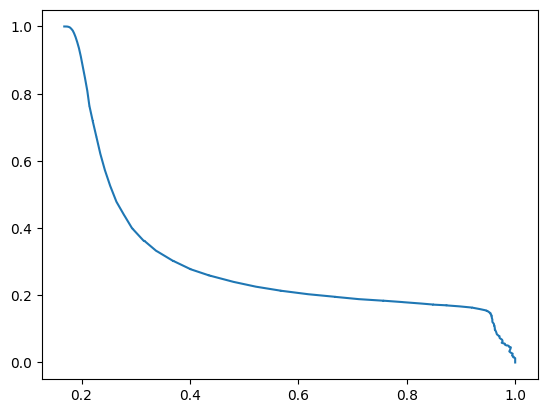

In [40]:
probs = pipe.predict_proba(X_test_embeding)

result = precision_recall_curve(
                        y_true=y_test.astype(int).values
                       , probas_pred=probs[:,1])

plt.plot(result[0], result[1])

[[-0.39651814  0.02384332  0.40667371 ... -0.87469853 -0.87469853
  -0.87469853]
 [-0.39651814  0.03268684  0.40667371 ... -0.18544856 -0.18544856
  -0.18544856]
 [-0.39651814  0.02384332  0.40667371 ... -0.64494854 -0.64494854
  -0.64494854]
 ...
 [-0.39651814  0.02384332  0.40667371 ... -0.64494854 -0.64494854
  -0.64494854]
 [-0.39651814  0.02384332  0.40667371 ...  0.9633014   0.9633014
   0.9633014 ]
 [-0.39651814  0.36946997 -0.72288347 ... -0.64494854 -0.64494854
  -0.64494854]]


              precision    recall  f1-score   support

       False       0.85      1.00      0.92     82776
        True       0.95      0.15      0.26     16731

    accuracy                           0.86     99507
   macro avg       0.90      0.57      0.59     99507
weighted avg       0.87      0.86      0.81     99507



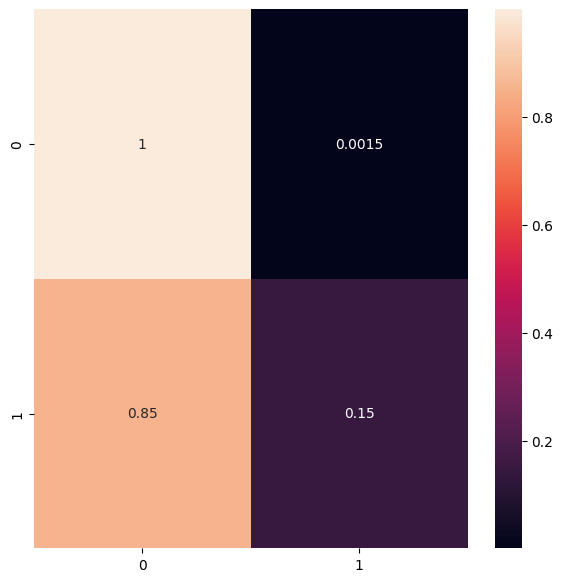

Exception ignored in: <function ResourceTracker.__del__ at 0x7f8d0d9884a0>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f3eb8d8c4a0>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fc8bff884a0>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multip

In [41]:
y_pred = pipe.predict(X_test_embeding)
classification_result(y_true=y_test.astype(str), y_pred=y_pred)